In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

import keras
from keras import layers
from keras.utils import to_categorical

from html import unescape

Using TensorFlow backend.


In [2]:
!python -m spacy download en_core_web_lg

import spacy
nlp = spacy.load('en_core_web_lg')


    Linking successful
    /opt/conda/lib/python3.6/site-packages/en_core_web_lg -->
    /opt/conda/lib/python3.6/site-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [3]:
### plotting ###
# prettier and larger basic graphs
sns.set(rc={
    'figure.figsize':(18,8),
    'axes.titlesize':14,
})

### pandas ###
# no need to see many decimal places and makes nicer horizontal fits :-)
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.precision = 3
# make the tables more compact vertically, too
pd.options.display.max_rows = 20

### numpy ###
# same as for pandas - max. 3 decimal places
np.set_printoptions(formatter={'float_kind':'{:.3f}'.format})
# np.set_printoptions(precision=3)

In [4]:
print(os.listdir("../input"))

['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


In [5]:
reviews_df = pd.read_csv('../input/drugsComTrain_raw.csv').sample(30000, random_state=0)
reviews_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
137738,48134,Nubain,Pain,"""I recently received an injection of nalbuphin...",9,30-May-11,12
125778,43221,Hydromorphone,Pain,"""I went to the emergency room in the worst pai...",10,4-Oct-17,1
26647,109628,Nexplanon,Birth Control,"""HORRIBLE! I was not myself at all. I cried ev...",1,14-Sep-16,7
89592,90397,Docosanol,Herpes Simplex,"""I use this medication daily and by doing this...",10,12-May-17,1
83605,6631,Primidone,Benign Essential Trem,"""Tremors seem to be getting worse. I take 2 a ...",3,8-Dec-16,10
105081,35875,Buprenorphine / naloxone,Opiate Dependence,"""My wife and I have been on Suboxone for about...",10,4-Jun-14,54
15387,170182,Quetiapine,Borderline Personality Disorde,"""Quitiapine turned my anxiety into anger and s...",1,21-Dec-16,16
112403,164074,Ibuprofen,Rheumatoid Arthritis,"""I had juvenile rheumatoid arthritis. I had a...",10,16-Nov-15,12
92541,123067,Ethinyl estradiol / norgestrel,Birth Control,"""This really helped me for my period, before t...",8,14-May-11,8
30749,94851,Abilify,Bipolar Disorde,"""Loving it so far, seems to be giving me a lif...",7,13-Dec-12,28


In [6]:
def clean_review(text):
    # replace HTML escaped characters and strip outer quotes and spaces
    return unescape(
        text.strip(' "\'').replace('/', ' ')
    )

reviews_df.review = reviews_df.review.apply(clean_review)

In [7]:
reviews_nlp = nlp.pipe(
    texts=reviews_df.review.values,
    disable=['tagger', 'parser', 'ner'],
)

reviews_df['review_vec_seq'] = None
reviews_df['review_vector'] = None

for index, review in zip(reviews_df.index, reviews_nlp):
    # transform the review to a sequence of vectors
    vec_seq = [
        token.vector if token.has_vector else nlp.vocab[token.lemma_].vector
        for token in review
    ]
    reviews_df.at[index, 'review_vec_seq'] = vec_seq
    reviews_df.at[index, 'review_vector'] = review.vector
    

In [8]:
# Check the new data
reviews_df.sample(20)

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_vec_seq,review_vector
13209,9783,Lo Loestrin Fe,Birth Control,Best I ever had!,10,14-Jun-15,0,"[[-0.51704, 0.32636, 0.13205, -0.2452, 0.45463...","[-0.1400638, 0.28034598, 0.006110591, -0.35610..."
140168,102653,Aripiprazole,Bipolar Disorde,I'm on Abilify in conjunction with Lamictal. I...,9,17-Mar-15,23,"[[0.18733, 0.40595, -0.51174, -0.55482, 0.0397...","[-0.034280233, 0.18095352, -0.08797183, -0.171..."
103055,39134,Contrave,Weight Loss,Just started my third week. No side effects so...,8,25-May-17,6,"[[-0.025563, 0.44424, -0.24555, -0.022672, 0.2...","[-0.0021355876, 0.2577304, -0.14841059, -0.062..."
26013,41889,Clonidine,Opiate Withdrawal,Been on oxy n morphs since early mid 90's had ...,5,26-May-16,51,"[[0.04122, 0.12696, -0.14441, -0.36391, -0.138...","[-0.022818482, 0.20389454, -0.15870778, -0.005..."
19495,21755,Guaifenesin / pseudoephedrine,Cough and Nasal Congestion,It's 2:30 am and I'm wide awake! At the sugges...,7,18-Feb-14,40,"[[0.0013629, 0.35653, -0.055497, -0.16607, 0.0...","[0.012822997, 0.33343634, -0.21424255, -0.0322..."
103673,84177,Ethinyl estradiol / norgestimate,Birth Control,I hate it so far. I'm not one to breakout and ...,4,30-Mar-17,5,"[[0.18733, 0.40595, -0.51174, -0.55482, 0.0397...","[-0.02751798, 0.22323732, -0.25085485, -0.1036..."
57158,215793,Copper,Birth Control,I'm a bit disappointed to read dozens of revi...,7,5-Nov-16,2,"[[0.18733, 0.40595, -0.51174, -0.55482, 0.0397...","[-0.032858543, 0.2070295, -0.1623073, -0.04492..."
25693,96526,Neurontin,Postherpetic Neuralgia,I'm on 300mg 3x a day. It's my lifesaver for n...,10,1-Aug-13,199,"[[0.18733, 0.40595, -0.51174, -0.55482, 0.0397...","[-0.03223112, 0.20946532, -0.17139983, -0.0631..."
145963,18651,Alosetron,Irritable Bowel Syndrome,"Have severe D-IBS since childhood, have never ...",9,31-Aug-12,21,"[[0.03567, 0.1856, -0.30552, -0.2512, -0.00022...","[-0.0033713959, 0.21918283, -0.19004488, -0.06..."
67625,77439,Prolia,Osteoporosis,I have been on Prolia for approximately two ye...,6,1-May-16,142,"[[0.18733, 0.40595, -0.51174, -0.55482, 0.0397...","[-0.048446137, 0.21259525, -0.2201448, -0.0527..."


In [9]:
MAX_SEQUENCE_LENGTH = 200
VOCABULARY_SIZE = 2000

In [10]:
sequence_lenghts = np.array([len(s) for s in reviews_df.review_vec_seq])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


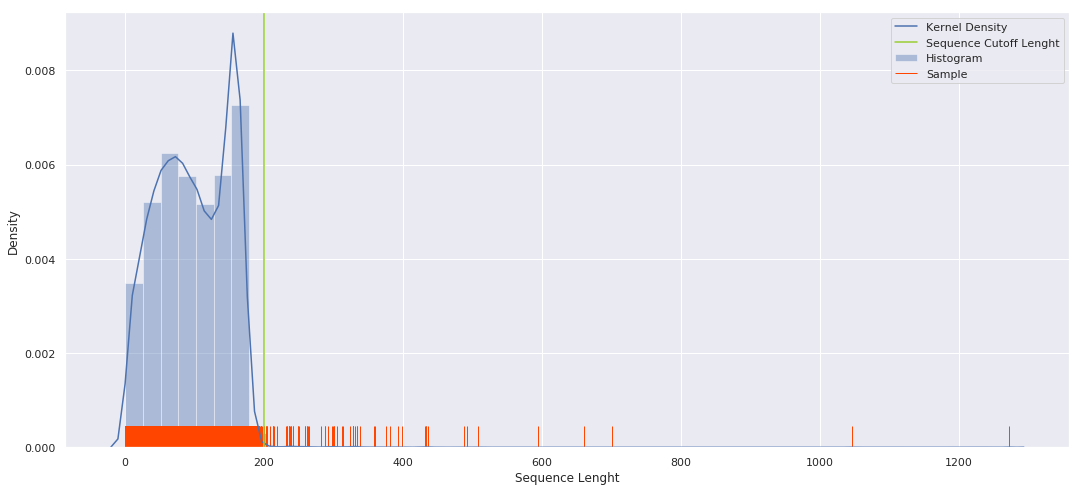

In [11]:
sns.distplot(
    sequence_lenghts,
    hist_kws=dict(label='Histogram'),
    kde=True,
    kde_kws=dict(label='Kernel Density'),
    rug=True,
    norm_hist=False,
    rug_kws=dict(color='orangered', label='Sample'),
    axlabel='Sequence Lenght',
)
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='yellowgreen', label='Sequence Cutoff Lenght')
plt.ylabel('Density')
plt.legend();

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


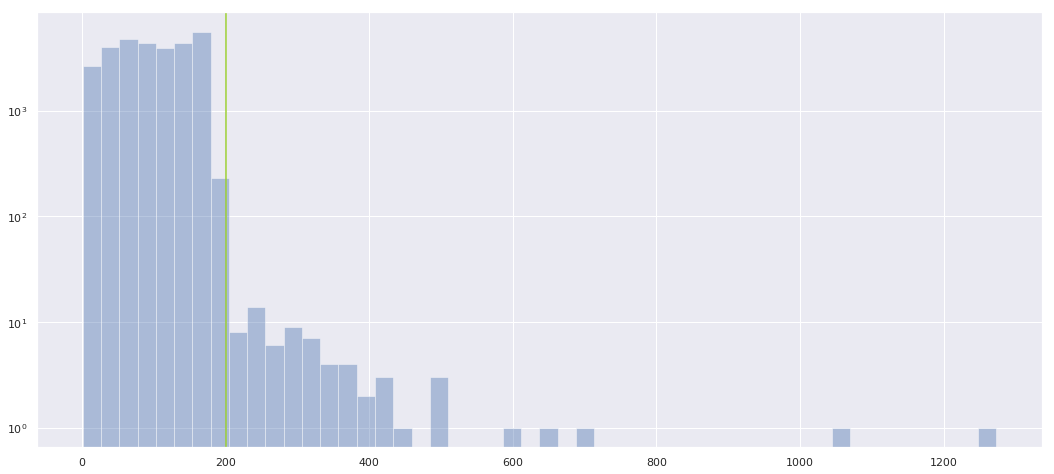

In [12]:
sns.distplot(sequence_lenghts, kde=False)
plt.gca().set_yscale('log')
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='yellowgreen');

In [13]:
sum(sequence_lenghts > MAX_SEQUENCE_LENGTH)/len(sequence_lenghts)

0.0023333333333333335

In [14]:
x_train = keras.preprocessing.sequence.pad_sequences(reviews_df.review_vec_seq, maxlen=MAX_SEQUENCE_LENGTH)
y_train = reviews_df.rating

In [15]:
# plotting

def plot_history(history, skip_first_n_epochs=0):
    """Show information about the training"""
    
    # plot every train-valid metric pair separately
    for metric in history:
        if not metric.startswith('val_'):
            x = np.arange(len(history[metric]))+1

            y_train = history[metric][skip_first_n_epochs:]
            y_valid = history['val_'+metric][skip_first_n_epochs:]

            # make the plots
            plt.plot(x, y_train)
            plt.plot(x, y_valid)

            # add a legend
            plt.legend([metric, 'val_'+metric], fontsize='large')

            # title with min/max stats
            plt.title(
                f'{metric.upper()} - '
                f'min/max [train: {min(y_train):.3f}/{max(y_train):.3f}, '
                f'valid: {min(y_valid):.3f}/{max(y_valid):.3f}]'
            )
            
            # label and show
            plt.xlabel('epoch')
            plt.show()

In [17]:
x_train.shape

(30000, 200, 300)

In [19]:
model = keras.models.Sequential()
model.add(layers.InputLayer(x_train.shape[1:]))
model.add(layers.CuDNNLSTM(64))
model.add(layers.Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 64)                93696     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 93,761
Trainable params: 93,761
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(
    optimizer='adam',
    loss='msle',
    metrics=['mae', 'mse'],
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_split=0.25,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            'model-epoch_{epoch:02d}-val_loss_{val_loss:.2f}.hdf5',
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            period=1,
        ),
    ],
)

plot_history(history.history)